In [1]:
import plotly.express as px
import xarray as xr
import plotly.graph_objects as go

def add_rectangle(fig, max_lat, min_lat, max_lon, min_lon, text=None):
    fig.add_trace(go.Scattermapbox(
        mode = "markers+lines",
        lon = [max_lon, min_lon, min_lon, max_lon, max_lon], lat = [max_lat, max_lat, min_lat, min_lat, max_lat],
        marker = {'size': 5, }))
    if text is not None:
        fig.add_trace(go.Scattermapbox(
            lon = [max_lon, min_lon, min_lon, max_lon, max_lon], lat = [max_lat, max_lat, min_lat, min_lat, max_lat],
            text = [text,text, text, text],  textfont = {'color': 'black', 'size': 10, 'family': "Courier New, monospace"},    textposition = "top right",
            ))
    return fig
    
figpath = "../../img/"
ds = xr.open_dataset("../../data/temp/netcdf/CTD_all_stations.nc")

mooring_loc = {"latitude": 64.612, "longitude": -50.954}

df_stations = ds.coords["latitude"].to_dataframe().reset_index()
df_stations.head()

fig = px.scatter_mapbox(df_stations.iloc[:,:-1], lat="latitude", lon="longitude", 
                        hover_name="station", hover_data=["station", "time", "latitude", "longitude"],
                        color="time",
                        color_continuous_scale=px.colors.cyclical.IceFire,
                        # # color_discrete_sequence=["fuchsia"], 
                        zoom=7, 
                        # height=300,
                        )

fig.add_trace(go.Scattermapbox(
    mode = "markers+text",
    lon = [mooring_loc["longitude"]], lat = [mooring_loc["latitude"]],
    text=["Mooring"],
    marker = {'size': 10, 'color': "black"},
    ))


fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})


# for i, station in enumerate([Puattorfik, Uuummannap_Sullua, KangersuneqGF12NorthSide, GF10NorthSide, GF3, Mouth]):
#     fig = add_rectangle(fig, station["latitude_max"], station["latitude_min"], station["longitude_max"], station["longitude_min"], text=station["name"])
# fig.update_layout(mapbox_style= "mapbox://styles/anneke-vries/cldmzfy3a003c01mwjiz2yj47", mapbox_accesstoken=token) # if you want to use a satellite background


# fig.write_image(f"{figpath}/map_with_selected_stations_osm.jpg")
fig.write_html(f"{figpath}/map_with_selected_stations_osm.html")


fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0}) 
fig.show()

In [37]:
import pandas as pd
df_selected_stations = pd.read_csv("../../data/temp/CTD_selected_stations_info.csv")
print("Total number of stations:", len(df_selected_stations["St.No."].unique()))
print("Total number of unique dates:", len(df_selected_stations["Date"].unique()))
# print unique Coordinates and format as table
# format as table
# find minimum longitude and maximum longitude and print as table

most_west_station = df_selected_stations[df_selected_stations.Longitude == df_selected_stations.Longitude.min()]
most_east_station = df_selected_stations[df_selected_stations.Longitude == df_selected_stations.Longitude.max()]
most_north_station = df_selected_stations[df_selected_stations.Latitude == df_selected_stations.Latitude.max()]
most_south_station = df_selected_stations[df_selected_stations.Latitude == df_selected_stations.Latitude.min()]

print(f"Westernmost station: {most_west_station.Coordinates.values[0]}")
print(f"Easternmost station: {most_east_station.Coordinates.values[0]}")
# most_west_station

Total number of stations: 150
Total number of unique dates: 37
Westernmost station: 64 8m 20.76s N, 51 50m 59.04s W
Easternmost station: 64 27m 5.7s N, 50 0m 48.42s W


# Example plots

## ADCP

In [16]:
!ls -l ../../data/raw

total 8
drwx------@ 5 annek  staff   160 Nov 21 09:59 CTD
drwx------  6 annek  staff   192 Nov 27 14:00 Moorings
-rw-r--r--@ 1 annek  staff  1137 Sep 26  2022 Stations GHF.csv


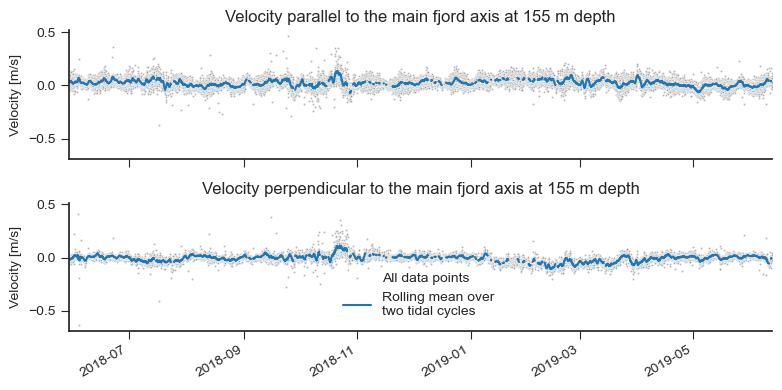

In [60]:
import xarray as xr
import matplotlib.pyplot as plt
fpathname = "../../data/processed/ADCP75_20180529_20190612_64.61_-50.95.nc"
figpath = "../../img/"



dataset = xr.open_dataset(fpathname)
dataset = dataset.load()
dataset.close()

plt.style.use('seaborn-ticks')
fig, axs = plt.subplots(2,1, figsize=(8, 4), sharex=True, sharey=True)
dataset.sel(z=150, method="nearest").Alongmpersec.plot.scatter(x="time", y="Alongmpersec", s=2, marker="o", color="black", alpha=0.5, label = "All data points", ax=axs[0])
dataset.sel(z=150, method="nearest").Alongmpersec.rolling(time=25, center=True).mean().plot(label="Rolling mean over \ntwo tidal cycles", ax=axs[0])  # 2 tidal cycles
axs[0].set_title('Velocity parallel to the main fjord axis at 155 m depth')

dataset.sel(z=150, method="nearest").Acrossmpersec.plot.scatter(x="time", y="Acrossmpersec", s=2, marker="o", color="black", alpha=0.5, label = "All data points", ax=axs[1])
dataset.sel(z=150, method="nearest").Acrossmpersec.rolling(time=25, center=True).mean().plot(label="Rolling mean over \ntwo tidal cycles", ax=axs[1], )  # 2 tidal cycles
axs[1].set_title('Velocity perpendicular to the main fjord axis at 155 m depth')
axs[1].legend()

plt.xlim(dataset.time.min(), dataset.time.max())
for ax in axs:
    ax.set_xlabel("")
    ax.set_ylabel("Velocity [m/s]")
    # remove spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(f"{figpath}/ADCP_timeseries_example.jpg", dpi=300)

## CTD profiles

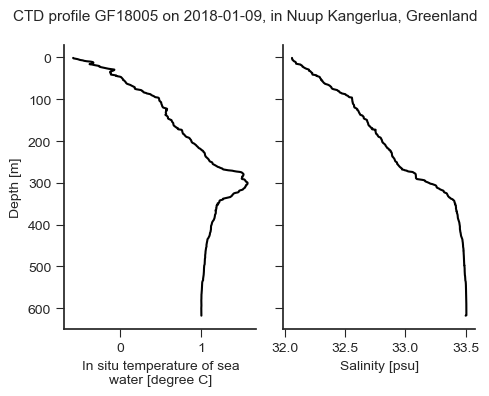

In [87]:
fpath = "../../data/temp/netcdf/single_profiles/CTD_GF18005_2018-01-09_64.38N_-51.59E.nc"

ds = xr.open_dataset(fpath)
ds = ds.load()
ds.close()

# plot all three variables with shared y axis in subplots
plt.style.use('seaborn-ticks')

fig, axs = plt.subplots(1,2, figsize=(5, 4), sharey=True)

ds["Temperature"].plot(ax=axs[0], y="Pressure [dbar]", color="black")
axs[0].set_ylabel("Depth [m]")
axs[0].invert_yaxis()

ds["Salinity"].plot(ax=axs[1], y="Pressure [dbar]", color="black")
axs[1].set_ylabel("")
fig.suptitle(ds.attrs["title"], fontsize=11)

# remove spines
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(f"{figpath}/CTD_profile_example.jpg", dpi=300)


In [81]:
ds

<xarray.Dataset>
Dimensions:                (Pressure [dbar]: 618)
Coordinates:
  * Pressure [dbar]        (Pressure [dbar]) float64 1.0 2.0 3.0 ... 617.0 618.0
Data variables:
    Potential temperature  (Pressure [dbar]) float64 -0.5868 -0.5842 ... 0.9759
    Salinity               (Pressure [dbar]) float64 32.06 32.06 ... 33.51 33.5
    Density                (Pressure [dbar]) float64 1.026e+03 ... 1.03e+03
Attributes: (12/30)
    user_name:              Anneke Vries
    data_type:              CTD
    featureType:            profile
    keywords:               EARTH SCIENCE>OCEANS>OCEAN TEMPERATURE>WATER TEMP...
    Conventions:            ACDD-1.3
    history:                2023-12-06T12:04:16Z converted to netcdf with xar...
    ...                     ...
    geospatial_lon_min:     -51.58755
    geospatial_lon_max:     -51.58755
    source:                 CTD #GF18005
    title:                  CTD profile GF18005 on 2018-01-09 00:00:00, in Nu...
    summary:                The file contains potential temperature, practica...
    GCRC_standard_station:  GF6